<h3>Required inputs:</h3>
<ol>
    <li>sorted fragments file</li>
    <li>peak file</li>
    <li>GTF file</li>
    <li>barcode file</li>
    <li>karyotype cluster file</li>
    <li>custom color map</li>
</ol>
<hr><br><br><br>

In [1]:
import time

import gzip
import pickle

import pandas as pd
import numpy as np
import scipy
import random

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from matplotlib.cm import get_cmap
import seaborn as sns

import anndata as ad
import scanpy as sc
import episcanpy as epi

In [2]:
with open("su006_cmap.pickle", "rb") as fh:
    cmap_clones = pickle.load(fh)
    
cmap_clones = cmap_clones[::-1]
cmap_clones

['#730002',
 '#ffb4b2',
 '#027300',
 '#5dd25d',
 '#b2ffb4',
 '#000473',
 '#494bb9',
 '#8e8ce6',
 '#b5b2ff']

In [3]:
cmap_tmp = get_cmap("tab10")
tab10 = [rgb2hex(cmap_tmp(i)) for i in range(cmap_tmp.N)]

cmap_tmp = get_cmap("Dark2")
dark2 = [rgb2hex(cmap_tmp(i)) for i in range(cmap_tmp.N)]

In [4]:
colors = ["gainsboro", "coral", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("cmap", colors)

In [5]:
name = "GSM3722057"

base_dir = "/home/hal9032/data/tmp/epianeufinder/"
new_dir = base_dir + "final/SU006pre_br15_msCNV0/"

fig_dir = new_dir + "figs/"
sc.settings.figdir = fig_dir

peak_file = base_dir + "{}_peaks.narrowPeak".format(name)
fragments_file = base_dir + "GSM3722057_SU006_Tumor_Pre_fragments_correctly_sorted.tsv.gz"

gtf_file = "/home/hal9032/data/gtfs/gencode.v39lift37.basic.annotation.gtf.gz"
gtf_file_uncompr = "/home/hal9032/data/gtfs/gencode.v39lift37.basic.annotation.gtf"

In [6]:
list_of_barcodes = pd.read_csv("{}SU006pre_br15_msCNV0_cluster_order.csv".format(new_dir))
list_of_barcodes["bc"] = [bc.replace("cell-", "") for bc in list_of_barcodes.x]
list_of_barcodes

,x,bc
0,cell-CAAAGCTTCTGTTTAC-1,CAAAGCTTCTGTTTAC-1
1,cell-ACCTGCTAGGATCCTT-1,ACCTGCTAGGATCCTT-1
2,cell-ATCCTCGGTAACGGCA-1,ATCCTCGGTAACGGCA-1
3,cell-ACTGCGGAGTGATCTC-1,ACTGCGGAGTGATCTC-1
4,cell-CTTGTCGGTTCGGGAA-1,CTTGTCGGTTCGGGAA-1
...,...,...
2035,cell-TCACCTGAGTCCCGCA-1,TCACCTGAGTCCCGCA-1
2036,cell-GCTCCTAAGGATTAAC-1,GCTCCTAAGGATTAAC-1
2037,cell-GCTCGAGAGAGCCACA-1,GCTCGAGAGAGCCACA-1
2038,cell-AGCCAGCGTAGTGATA-1,AGCCAGCGTAGTGATA-1


In [7]:
valid_barcodes = list_of_barcodes.bc.to_list()[::-1]
valid_barcodes[:10]

['TTTGTGTCACTGATAC-1',
 'AGCCAGCGTAGTGATA-1',
 'GCTCGAGAGAGCCACA-1',
 'GCTCCTAAGGATTAAC-1',
 'TCACCTGAGTCCCGCA-1',
 'GGGACCTGTCACTCTC-1',
 'TAGCGGCTCTGAACGT-1',
 'AGTGCGCTCGGTCTAA-1',
 'GTAGTACCAATCAGGG-1',
 'ACCATCCAGTTAGAGT-1']

In [8]:
with open("{}SU006pre_br15_msCNV0_clusters_level9.csv".format(new_dir)) as fh:
    
    cluster_labels = fh.readline()
    cluster_labels = cluster_labels.strip().split("\t")
    cluster_labels = [x.lstrip("cluster") for x in cluster_labels]
    
    cluster_dict = {x: [] for x in cluster_labels}
    
    for line in fh:
        line = line.strip().split("\t")
        line = [x.lstrip("ncell-").rstrip(")") if not x.startswith("Cell-") else x[5:].lstrip("ncell-").rstrip(")") for x in line]
        
        for i, barcode in enumerate(line):
            if barcode:
                cluster_dict[cluster_labels[i]].append(barcode)
                
print(np.sum([len(v) for v in cluster_dict.values()]))

karyotype_per_barcode = {barcode: k for k, v in cluster_dict.items() for barcode in v}

2040


<br><br><br><hr><h3>COUNT MATRICES</h3>

In [9]:
adata = epi.ct.peak_mtx(
    fragments_file,
    peak_file, 
    valid_barcodes,
    normalized_peak_size=None,
    fast=True
)

adata

AnnData object with n_obs × n_vars = 2040 × 185113
    var: 'chr', 'start', 'stop'

In [10]:
epi.tl.find_genes(adata,
                  gtf_file=gtf_file_uncompr,
                  key_added="gene_annotation",
                  upstream=5000,
                  feature_type="gene",
                  annotation="HAVANA",
                  raw=True)

In [11]:
adata.obs["karyotype"] = [karyotype_per_barcode[bc] for bc in adata.obs.index]
adata.obs

,karyotype
TTTGTGTCACTGATAC-1,1
AGCCAGCGTAGTGATA-1,1
GCTCGAGAGAGCCACA-1,1
GCTCCTAAGGATTAAC-1,1
TCACCTGAGTCCCGCA-1,1
...,...
CTTGTCGGTTCGGGAA-1,6
ACTGCGGAGTGATCTC-1,6
ATCCTCGGTAACGGCA-1,6
ACCTGCTAGGATCCTT-1,6


In [12]:
tmp = ["1.1", "1.2", "2.1", "2.2.1", "2.2.2", "3.1", "3.2.1", "3.2.2", "3.2.3"][::-1]
karyo_map = {x: tmp[i] for i, x in enumerate(adata.obs.karyotype.unique().tolist())}

adata.obs["karyotype"] = [karyo_map[x] for x in adata.obs.karyotype]

adata.obs.karyotype.unique().tolist()

['3.2.3', '3.2.2', '3.2.1', '3.1', '2.2.2', '2.2.1', '2.1', '1.2', '1.1']

In [13]:
gene_activity = epi.ct.gene_activity_mtx(
    fragments_file,
    gtf_file,
    valid_barcodes,
    upstream=2000,
    downstream=0,
    source="HAVANA",
    gene_type=["protein_coding"],
    fast=True
)

gene_activity

AnnData object with n_obs × n_vars = 2040 × 19996
    var: 'gene_name', 'gene_id', 'gene_type', 'chr', 'start', 'stop', 'strand', 'source'

In [14]:
gene_activity.obs["karyotype"] = [karyotype_per_barcode[bc] for bc in gene_activity.obs.index]
gene_activity.obs

,karyotype
TTTGTGTCACTGATAC-1,1
AGCCAGCGTAGTGATA-1,1
GCTCGAGAGAGCCACA-1,1
GCTCCTAAGGATTAAC-1,1
TCACCTGAGTCCCGCA-1,1
...,...
CTTGTCGGTTCGGGAA-1,6
ACTGCGGAGTGATCTC-1,6
ATCCTCGGTAACGGCA-1,6
ACCTGCTAGGATCCTT-1,6


In [15]:
tmp = ["1.1", "1.2", "2.1", "2.2.1", "2.2.2", "3.1", "3.2.1", "3.2.2", "3.2.3"][::-1]
karyo_map = {x: tmp[i] for i, x in enumerate(gene_activity.obs.karyotype.unique().tolist())}

gene_activity.obs["karyotype"] = [karyo_map[x] for x in gene_activity.obs.karyotype]

gene_activity.obs.karyotype.unique().tolist()

['3.2.3', '3.2.2', '3.2.1', '3.1', '2.2.2', '2.2.1', '2.1', '1.2', '1.1']

In [16]:
with open(f"{new_dir}su006_peaks_checkpoint.pickle", "wb") as fh:
    pickle.dump(adata, fh)

with open(f"{new_dir}su006_gene_activity_checkpoint.pickle", "wb") as fh:
    pickle.dump(gene_activity, fh)

In [17]:
with open(f"{new_dir}su006_peaks_checkpoint.pickle", "rb") as fh:
    adata = pickle.load(fh)

with open(f"{new_dir}su006_gene_activity_checkpoint.pickle", "rb") as fh:
    gene_activity = pickle.load(fh)

In [18]:
sc.pp.normalize_total(gene_activity)

<br><br><br><hr><h3>QC</h3>

In [19]:
if np.max(adata.X) > 1:
    epi.pp.binarize(adata)

In [20]:
epi.pp.lazy_qc(adata, fragments=fragments_file, gtf=gtf_file)

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features, nucleosome_signal, tss_enrichment_score to .obs


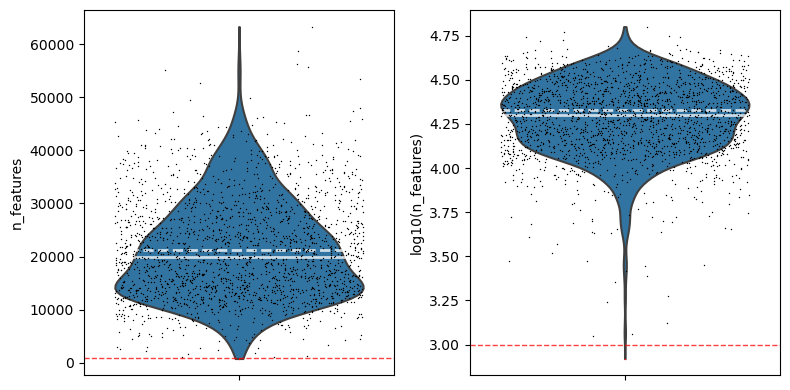

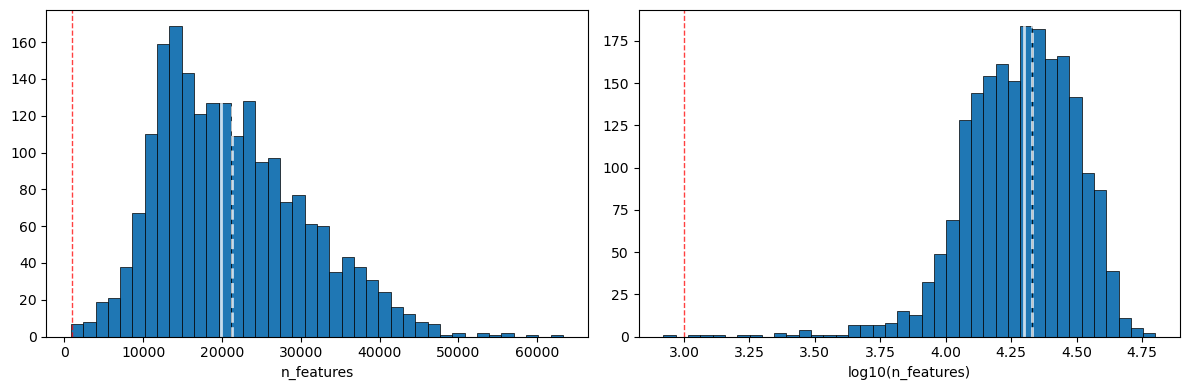

Max:	63275
Median:	19875.5
Mean:	21285.351960784315
Min:	834


In [21]:
min_features = 1000
max_features = None

epi.pl.violin(adata, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata, "n_features", bins=40, min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

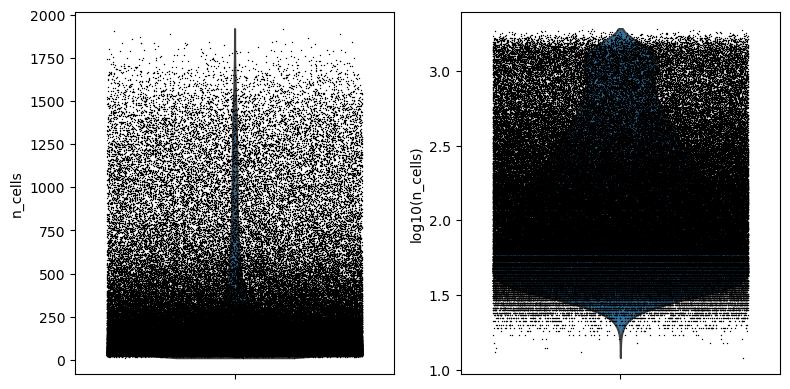

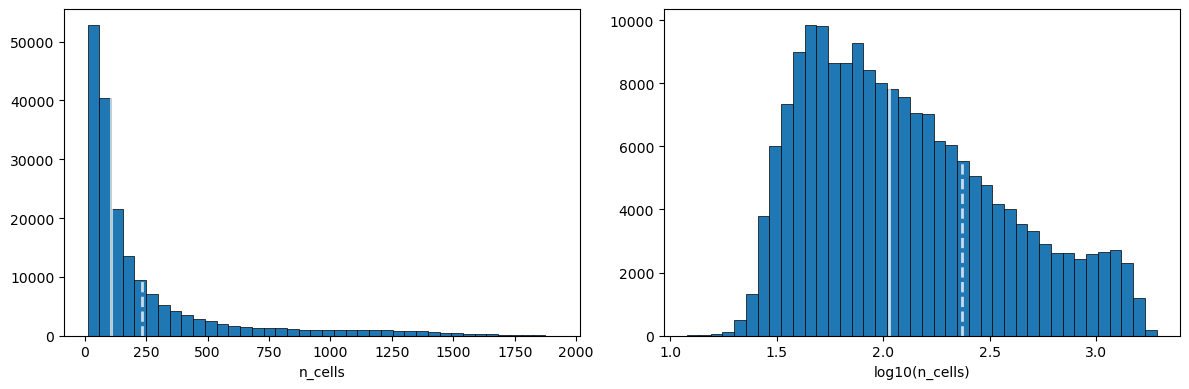

Max:	1921
Median:	106.0
Mean:	234.57087292626665
Min:	12


In [22]:
min_cells = None
max_cells = None

epi.pl.violin(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata, "n_cells", bins=40, min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

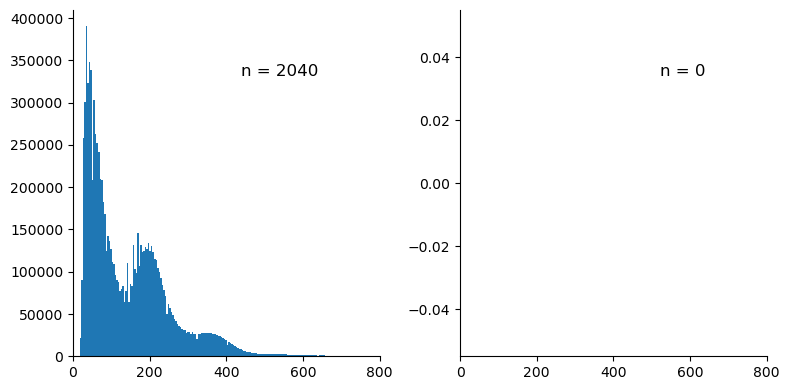

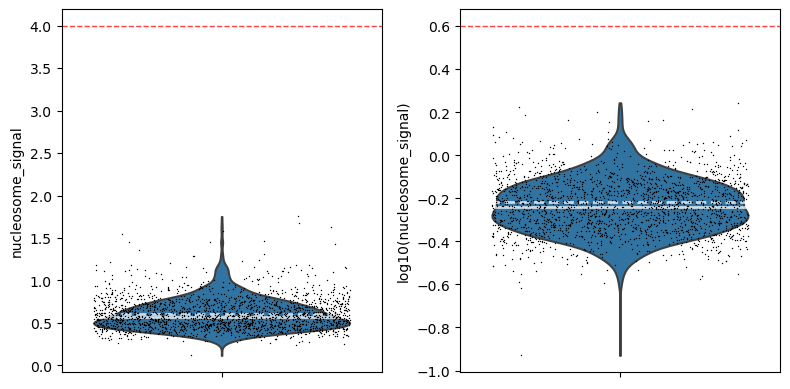

Max:	1.7534479559651184
Median:	0.5753269466172299
Mean:	0.6057116241588598
Min:	0.11754601226993865


In [23]:
max_nucleosome_signal = 4

epi.pl.fragment_length(adata, n=5000, threshold=max_nucleosome_signal, show_n=True)
epi.pl.violin(adata, "nucleosome_signal", max_threshold=max_nucleosome_signal, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

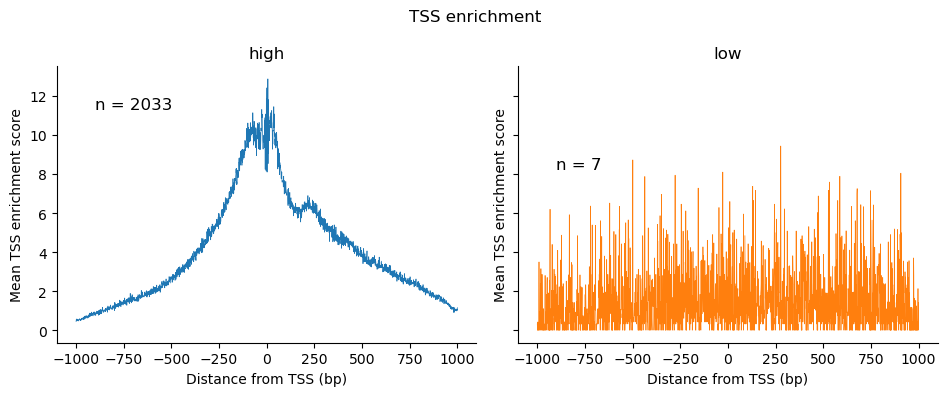

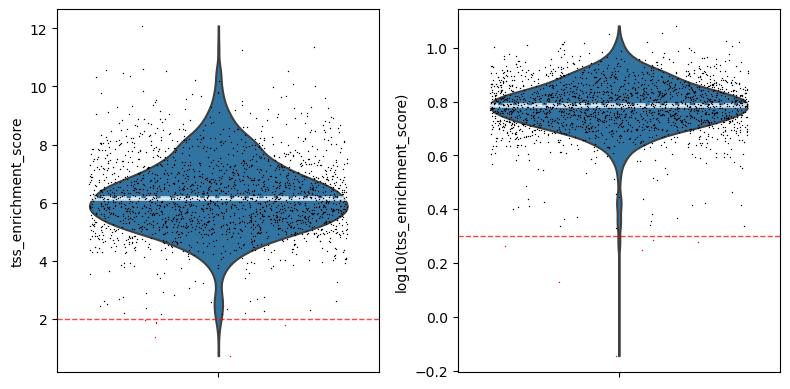

Max:	12.094155844155845
Median:	6.105604968831241
Mean:	6.197736945533544
Min:	0.715950715950716


In [24]:
min_tss_enrichment = 2

adata.obs["tss"] = ["high" if val > min_tss_enrichment else "low" for val in adata.obs.tss_enrichment_score]

epi.pl.tss_enrichment(adata, group_by="tss", show_n=True)
epi.pl.violin(adata, "tss_enrichment_score", min_threshold=min_tss_enrichment, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

<br><hr><br><br><h3>FEATURE SELECTION</h3>

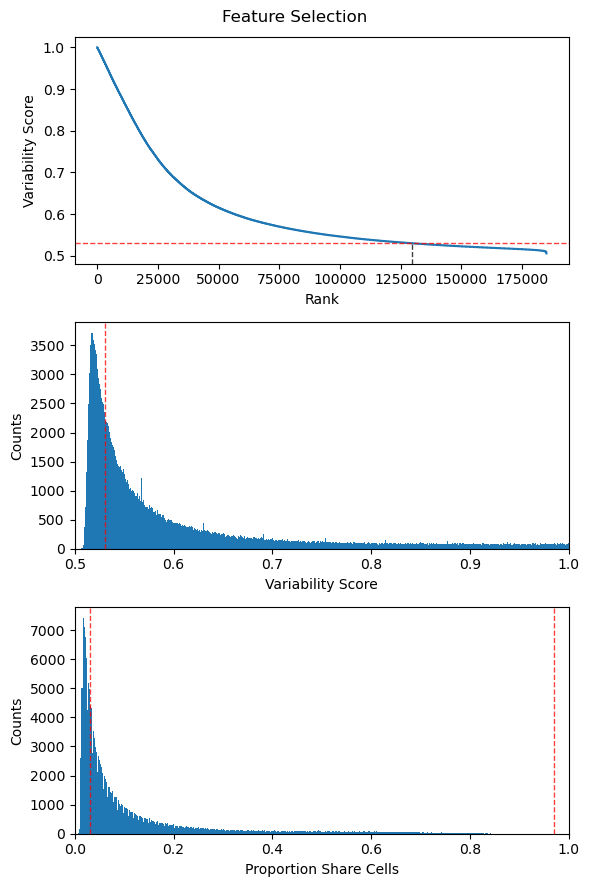

In [25]:
epi.pp.highly_variable(adata, min_score=0.53, n_features=None)

In [26]:
adata = epi.pp.select_highly_variable(adata, verbose=True)

129764 of 185113 features remain (-55349)


<br><hr><br><br><h3>NORMALIZATION</h3>

In [27]:
epi.pp.normalize_total(adata)
epi.pp.log1p(adata)

<br><hr><br><br><h3>EMBEDDING</h3>

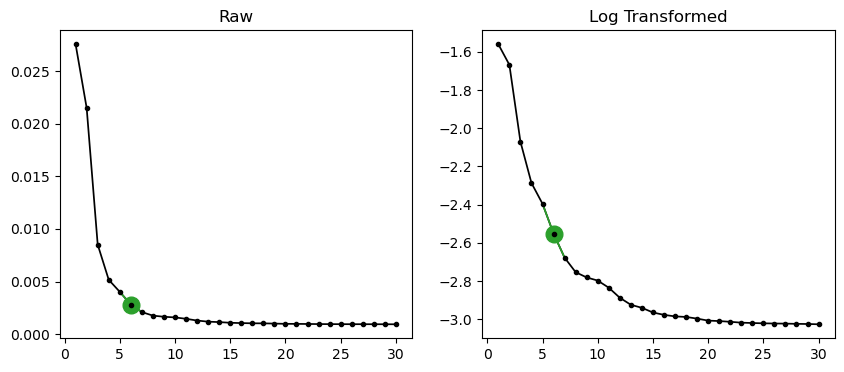

In [28]:
epi.pp.pca(adata, n_comps=30)
n_comps = epi.pp.find_elbow(adata, use_log=False, show_anno=False)

In [29]:
epi.pp.neighbors(adata, n_pcs=n_comps, method="umap")
epi.tl.umap(adata)

In [30]:
adata.obs["karyotype"] = adata.obs.karyotype.astype("category")

colors = {x: cmap_clones[i] for i, x in enumerate(adata.obs.karyotype.cat.categories)}
colors

{'1.1': '#730002',
 '1.2': '#ffb4b2',
 '2.1': '#027300',
 '2.2.1': '#5dd25d',
 '2.2.2': '#b2ffb4',
 '3.1': '#000473',
 '3.2.1': '#494bb9',
 '3.2.2': '#8e8ce6',
 '3.2.3': '#b5b2ff'}

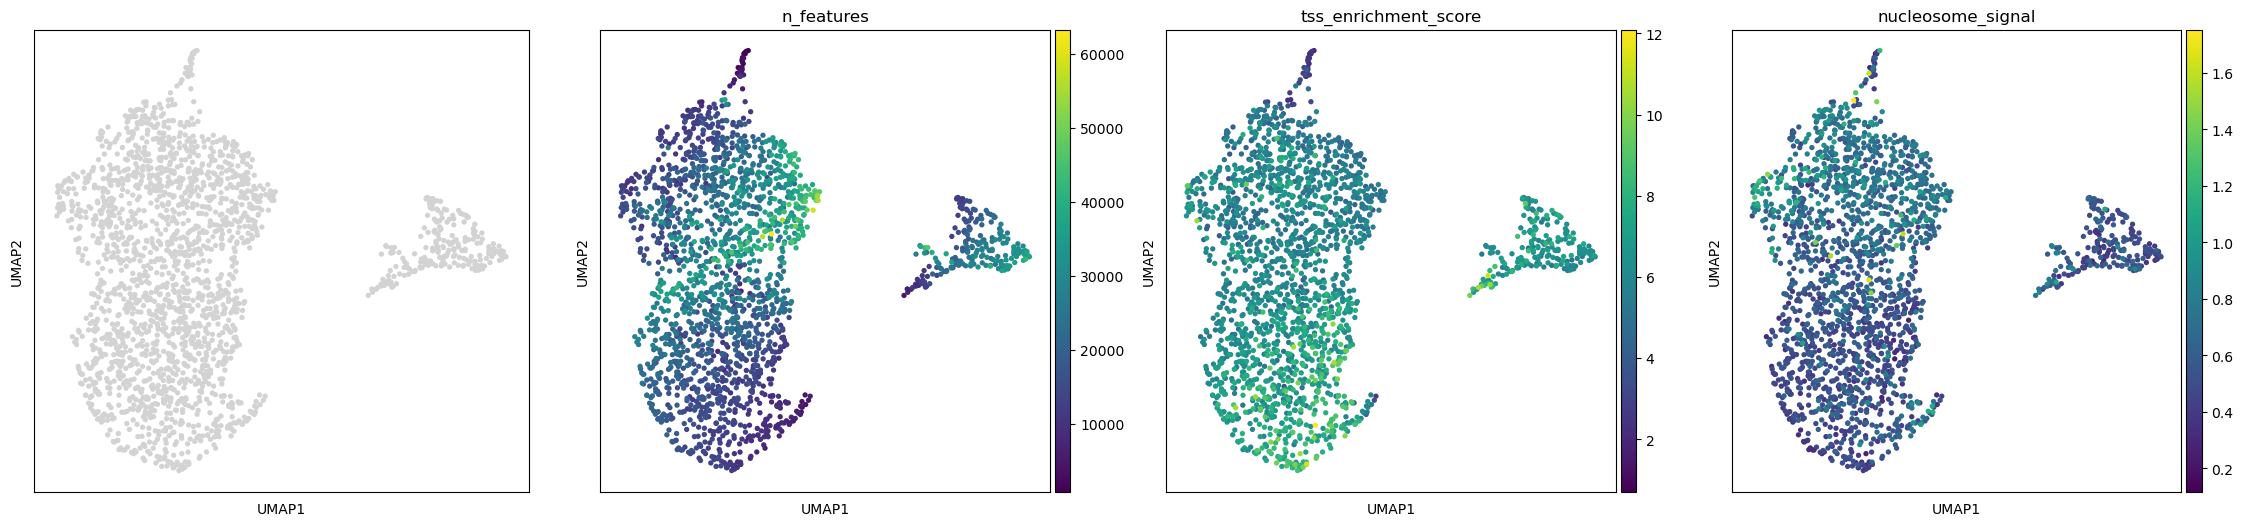

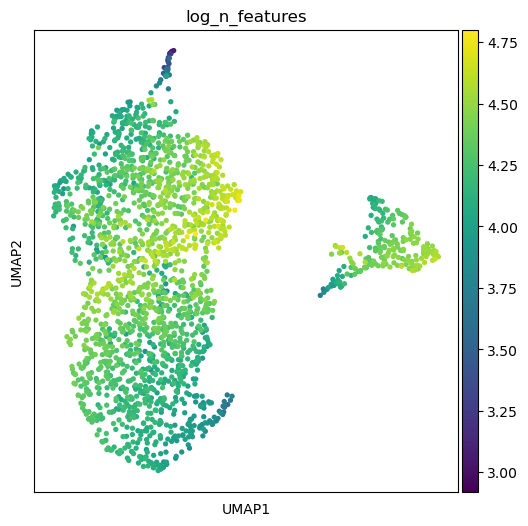

In [31]:
plt.rcParams["figure.figsize"]= (6, 6)
epi.pl.umap(adata, color=[None, "n_features", "tss_enrichment_score", "nucleosome_signal"], ncols=4, save="_qc.png")
epi.pl.umap(adata, color=["log_n_features"], ncols=4, save="_nfeat.png")

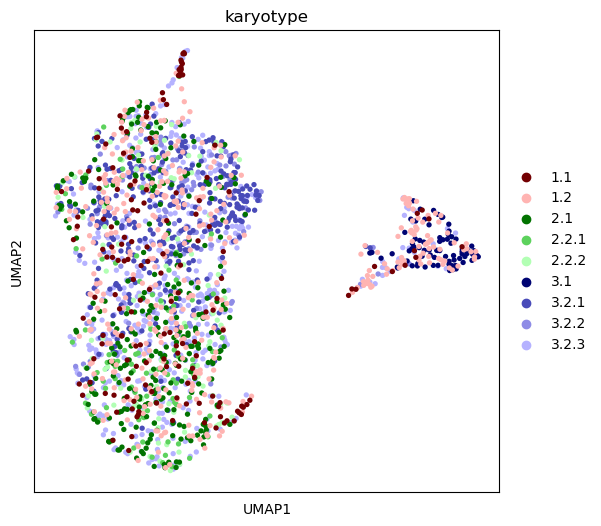

In [32]:
epi.pl.umap(adata, color=["karyotype"], palette=colors, ncols=2, save="_karyotypes.png")

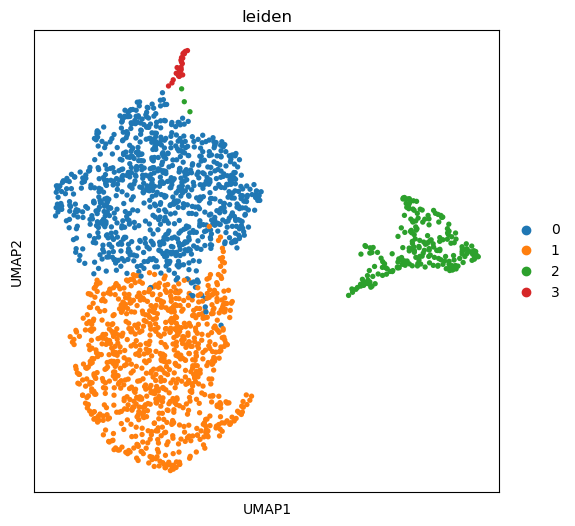

In [33]:
epi.tl.leiden(adata, resolution=0.15)
epi.pl.umap(adata, color=["leiden"], ncols=2)

<br><hr><br><br><h3>TRANSFER EMBEDDING TO GENE ACTIVITY</h3>

In [34]:
gene_activity.obsm["X_umap"] = adata.obsm["X_umap"]
gene_activity.var.index = gene_activity.var.gene_name
gene_activity.layers["log"] = np.log1p(gene_activity.X)

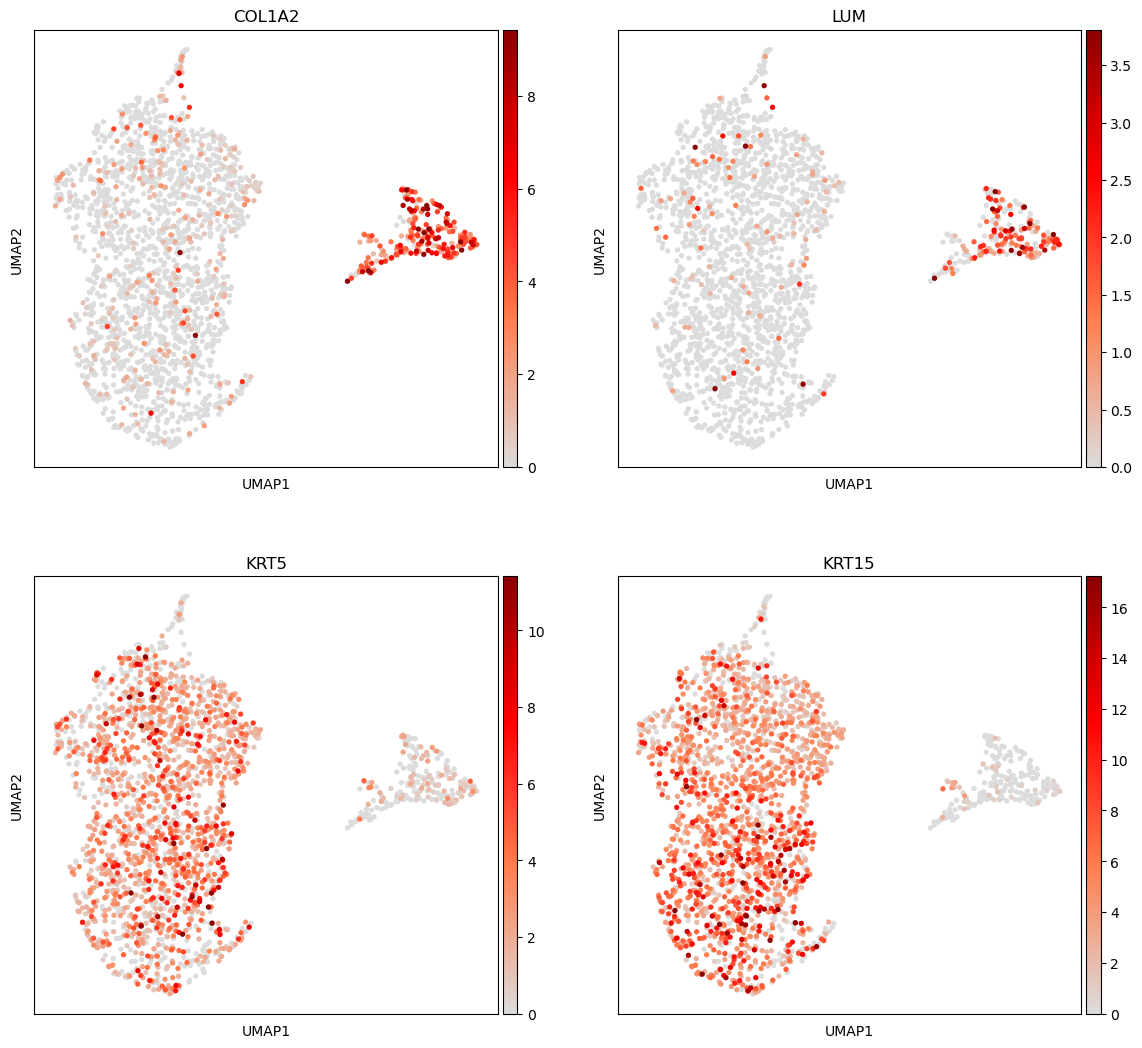

In [35]:
cell_type_markers = ["COL1A2", "LUM", "KRT5", "KRT15"]
vmaxs = [np.percentile(np.ravel(gene_activity[:, gene].X.todense()), 99.5) for gene in cell_type_markers]

epi.pl.umap(gene_activity, color=cell_type_markers, vmax=vmaxs, color_map=cmap, ncols=2, save="_cell_type_markers.png")

<br><hr><br><br><h3>ANNOTATE CLUSTERS</h3>

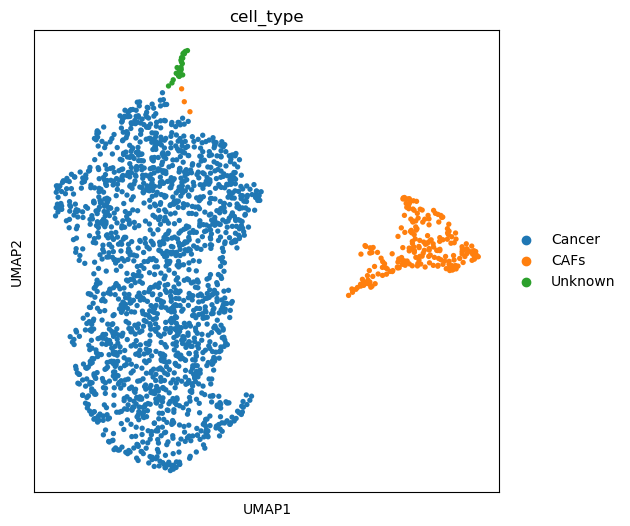

In [36]:
anno_map = {
    "0": "Cancer",
    "1": "Cancer",
    "2": "CAFs",
    "3": "Unknown"
}
adata.obs["cell_type"] = [anno_map[cluster] for cluster in adata.obs.leiden]

adata.obs["cell_type"] = adata.obs.cell_type.astype("category")
adata.obs["cell_type"] = adata.obs.cell_type.cat.reorder_categories(["Cancer", "CAFs", "Unknown"])

epi.pl.umap(adata, color=["cell_type"], vmax=vmaxs, color_map=cmap, ncols=2, save="_cell_types.png")

In [37]:
ctype_per_bc = {k: v for k, v in zip(adata.obs.index, adata.obs.cell_type)}

with open(f"{base_dir}{name}_clusters.pickle", "wb") as fh:
    pickle.dump(ctype_per_bc, fh)

In [38]:
gene_activity.obs["cell_type"] = [ctype_per_bc[bc] for bc in gene_activity.obs.index]

gene_activity.obs["cell_type"] = gene_activity.obs.cell_type.astype("category")
gene_activity.obs["cell_type"] = gene_activity.obs.cell_type.cat.reorder_categories(["Cancer", "CAFs", "Unknown"])

<br><hr><br><br><h3>COMPOSITION</h3>

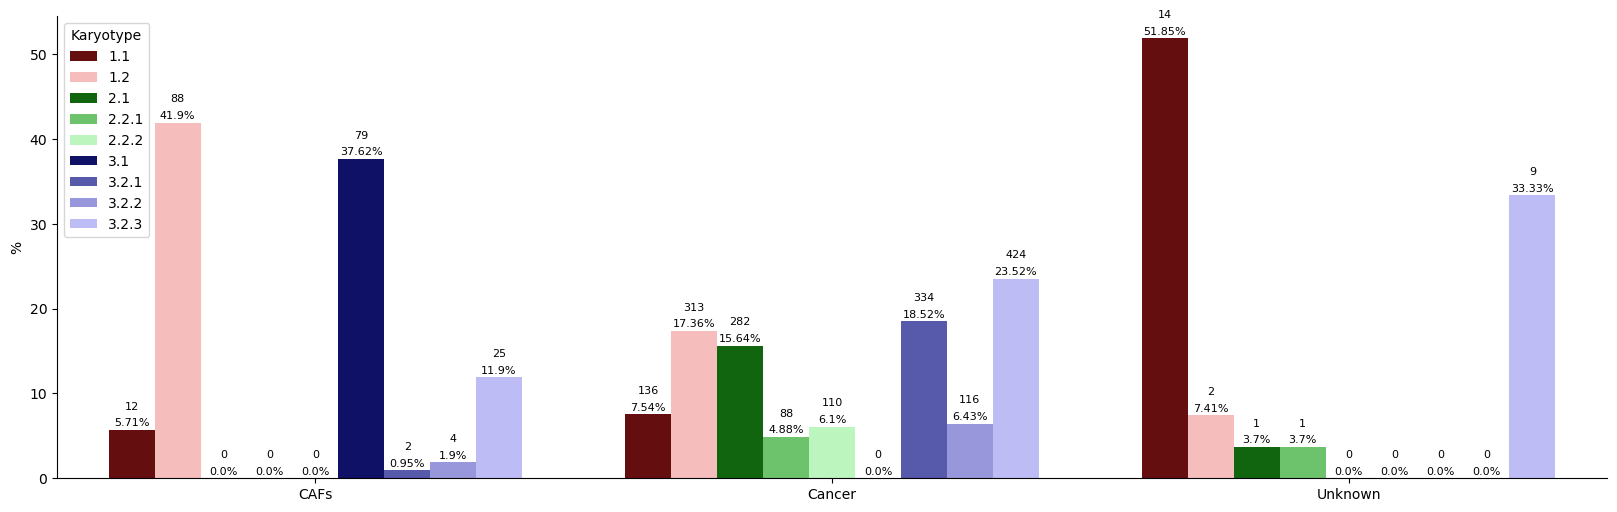

In [39]:
res = {"cell_type": [], "karyotype": [], "pct": [], "n": []}

for c_1 in adata.obs.cell_type.unique():
    
    n_total = adata.obs[adata.obs.cell_type == c_1].shape[0]

    tmp = adata.obs[adata.obs.cell_type == c_1].karyotype.value_counts()
    tmp = tmp.to_dict()

    for c_2, n in tmp.items():
        res["cell_type"].append(c_1)
        res["karyotype"].append(c_2)
        res["n"].append(n)
        res["pct"].append(np.round((n / n_total) * 100, decimals=2))
        
res = pd.DataFrame(res)
res = res.sort_values(by=["cell_type", "karyotype"], ignore_index=True)

fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=1, squeeze=True)

sns.barplot(data=res, x="cell_type", y="pct", hue="karyotype", palette=cmap_clones, ax=ax)

for i, p in enumerate(ax.patches):
    ax.annotate(text="{}%".format(res.sort_values(by=["karyotype", "cell_type"], ignore_index=True).pct[i]),
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5),
                textcoords="offset points",
                fontsize=8,
                ha="center",
                va="center")
    ax.annotate(text=res.sort_values(by=["karyotype", "cell_type"], ignore_index=True).n[i],
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5 + 12),
                textcoords="offset points",
                fontsize=8,
                ha="center",
                va="center")
    
ax.set_xlabel("")
ax.set_ylabel("%")
ax.legend(title="Karyotype")

sns.despine()
plt.savefig(fig_dir + "karyotype_per_cell_type.png", dpi=300)

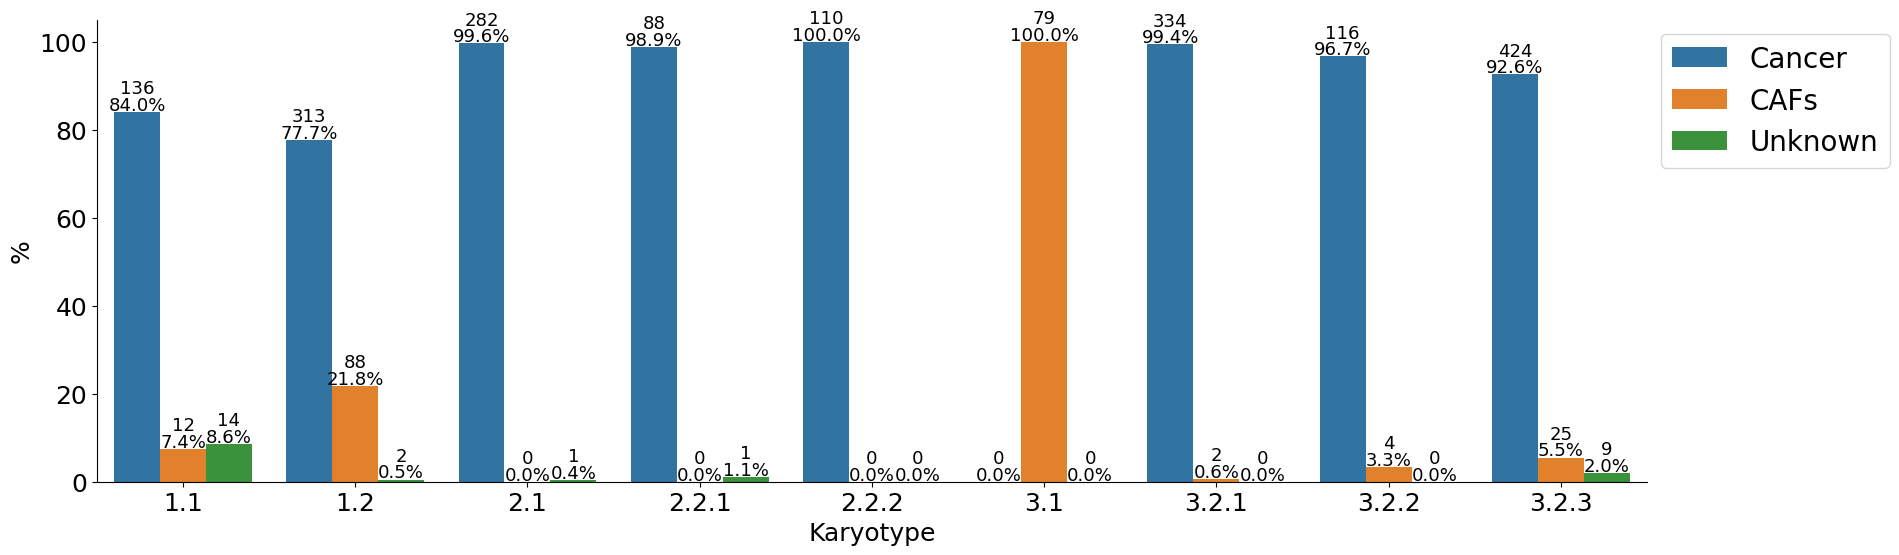

In [40]:
res = {"cell_type": [], "karyotype": [], "pct": [], "n": []}

for c_1 in adata.obs.karyotype.unique():
    
    n_total = adata.obs[adata.obs.karyotype == c_1].shape[0]

    tmp = adata.obs[adata.obs.karyotype == c_1].cell_type.value_counts()
    tmp = tmp.to_dict()

    for c_2, n in tmp.items():
        res["karyotype"].append(c_1)
        res["cell_type"].append(c_2)
        res["n"].append(n)
        res["pct"].append(np.round((n / n_total) * 100, decimals=1))
        
res = pd.DataFrame(res)
res["cell_type"] = res.cell_type.astype("category")
res["cell_type"] = res.cell_type.cat.reorder_categories(["Cancer", "CAFs", "Unknown"])
res = res.sort_values(by=["karyotype", "cell_type"], ignore_index=True)

fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=1, squeeze=True)

sns.barplot(data=res, x="karyotype", y="pct", hue="cell_type", ax=ax)

for i, p in enumerate(ax.patches):
    ax.annotate(text="{}%".format(res.sort_values(by=["cell_type", "karyotype"], ignore_index=True).pct[i]),
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5),
                textcoords="offset points",
                fontsize=13,
                ha="center",
                va="center")
    ax.annotate(text=res.sort_values(by=["cell_type", "karyotype"], ignore_index=True).n[i],
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5 + 12),
                textcoords="offset points",
                fontsize=13,
                ha="center",
                va="center")
    
ax.set_xlabel("Karyotype", fontsize=18)
ax.set_ylabel("%", fontsize=18)
ax.legend(bbox_to_anchor=(1., 1), fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=18)

sns.despine()
plt.savefig(fig_dir + "cell_type_per_karyotype.png", dpi=300, bbox_inches="tight")

<br><hr><br><br><h3>MARKERS</h3>

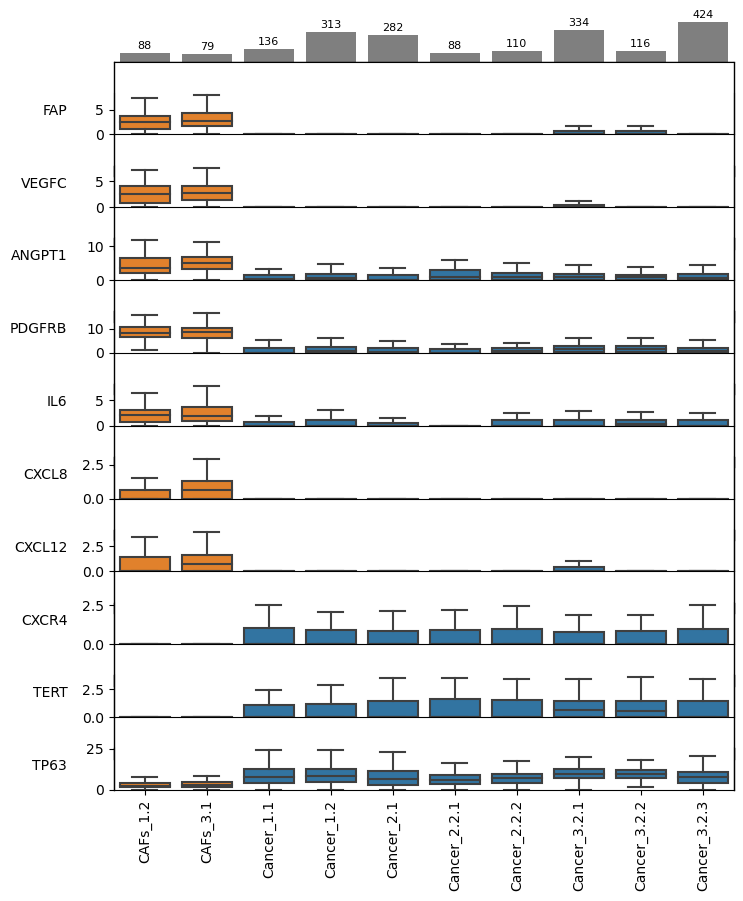

In [41]:
tmp_adata = gene_activity[gene_activity.obs.cell_type.isin(["Cancer", "CAFs"]), :].copy()

tmp_adata.obs["x"] = ["{}_{}".format(x, y) for x, y in zip(tmp_adata.obs.cell_type, tmp_adata.obs.karyotype)]
tmp_adata.obs["x"] = tmp_adata.obs.x.astype("category")

# minimum threshold for categories to be plotted
valid = {}
for idx, val in tmp_adata.obs.x.value_counts().iteritems():
    frac = val / tmp_adata.obs.karyotype.value_counts()[idx.split("_")[1]]
    valid[idx] = frac > 0.2
tmp_adata = tmp_adata[[valid[x] for x in tmp_adata.obs.x]].copy()

class_counts = tmp_adata.obs.x.value_counts(sort=False)

col_map = {
    "Cancer": tab10[0],
    "CAFs": tab10[1],
    "Endothelial": tab10[3]
}
col_pal = [col_map[x.split("_")[0]] for x in tmp_adata.obs.x.cat.categories]

tmp = ["FAP", "VEGFC", "ANGPT1", "PDGFRB", "IL6", "CXCL8", "CXCL12", "CXCR4", "TERT", "TP63"]

fig, axs = plt.subplots(figsize=(8,10), nrows=len(tmp)+1, ncols=1, squeeze=False)
axs = axs.flatten()

plt.subplots_adjust(hspace=0.75)

ax = axs[0]

sns.barplot(x=class_counts.index, y=class_counts, color="tab:grey", ax=ax)

for i, p in enumerate(ax.patches):
    
    ax.annotate(text=f"{p.get_height():n}",
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5),
                textcoords="offset points",
                fontsize=8,
                ha="center",
                va="center")

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("")
ax.set_ylabel("", rotation=0, ha="right")

ax.yaxis.set_label_coords(-0.025, 0.4)
sns.despine(bottom=False, left=True, ax=ax)

ax.axhline(linewidth=1, color="black")

for i, marker in enumerate(tmp):
    
    i += 1
    
    ax = axs[i]

    sns.boxplot(
        x=tmp_adata.obs.x.tolist(), 
        y=np.array(tmp_adata[:, tmp_adata.var.gene_name == marker].X.todense()).flatten(),
        order=tmp_adata.obs.x.cat.categories,
        palette=col_pal,
        orient="v",
        showfliers=False,
        ax=ax
    )
    
    ax.set_xlabel("")
    ax.set_ylabel(marker, rotation=0, ha="right")
    ax.yaxis.set_label_coords(-0.075, 0.4)
    
    tmp_ticks = ax.get_xticks()
    ax.tick_params(axis="x", labelrotation=90)
    
    ax.set_ylim((0, None))
    
    xmin, xmax = ax.get_xlim()
    
    if i == 1:
        ax.axvline(x=xmin, ymin=-1, ymax=1.75, clip_on=False, color="black", linewidth=1.0)
        ax.axvline(x=xmax, ymin=-1, ymax=1.75, clip_on=False, color="black", linewidth=1.0)
        ax.set_xticks([])
        sns.despine(bottom=False, top=True, right=False, ax=ax)
    elif i != len(tmp):
        ax.axvline(x=xmin, ymin=-1, clip_on=False, color="black", linewidth=1.0)
        ax.axvline(x=xmax, ymin=-1, clip_on=False, color="black", linewidth=1.0)
        ax.set_xticks([])
        sns.despine(bottom=False, right=False, ax=ax)
    else:
        ax.axvline(x=xmin, ymin=0, clip_on=False, color="black", linewidth=1.0)
        ax.axvline(x=xmax, ymin=0, clip_on=False, color="black", linewidth=1.0)
        sns.despine(right=False, ax=ax)

plt.savefig("{}boxplot_caf_and_cancer_markers.png".format(fig_dir), dpi=600, bbox_inches="tight")

<br><br><br><hr><h3>WINDOWS</h3>

In [42]:
windows = epi.ct.window_mtx(
    fragments_file,
    valid_barcodes,
    window_size=100000,
    species="human",
    fast=True
)

windows

AnnData object with n_obs × n_vars = 2040 × 30877
    var: 'chr', 'start', 'stop'

In [43]:
windows.obs["karyotype"] = [karyotype_per_barcode[bc] for bc in windows.obs.index]
windows.obs

,karyotype
TTTGTGTCACTGATAC-1,1
AGCCAGCGTAGTGATA-1,1
GCTCGAGAGAGCCACA-1,1
GCTCCTAAGGATTAAC-1,1
TCACCTGAGTCCCGCA-1,1
...,...
CTTGTCGGTTCGGGAA-1,6
ACTGCGGAGTGATCTC-1,6
ATCCTCGGTAACGGCA-1,6
ACCTGCTAGGATCCTT-1,6


In [44]:
tmp = ["1.1", "1.2", "2.1", "2.2.1", "2.2.2", "3.1", "3.2.1", "3.2.2", "3.2.3"][::-1]
karyo_map = {x: tmp[i] for i, x in enumerate(windows.obs.karyotype.unique().tolist())}

windows.obs["karyotype"] = [karyo_map[x] for x in windows.obs.karyotype]

windows.obs.karyotype.unique().tolist()

['3.2.3', '3.2.2', '3.2.1', '3.1', '2.2.2', '2.2.1', '2.1', '1.2', '1.1']

In [45]:
windows.obs["cell_type"] = [ctype_per_bc[bc] for bc in windows.obs.index]

windows.obs["cell_type"] = windows.obs.cell_type.astype("category")
windows.obs["cell_type"] = windows.obs.cell_type.cat.reorder_categories(["Cancer", "CAFs", "Unknown"])

In [46]:
epi.pp.qc_stats(windows, verbose=True)

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features, n_counts, log_n_counts to .obs


In [47]:
print(windows.n_vars)
windows = windows[:, windows.var.n_cells > 0].copy()
print(windows.n_vars)

30877
28510


In [48]:
sc.pp.normalize_total(windows)
sc.pp.log1p(windows)

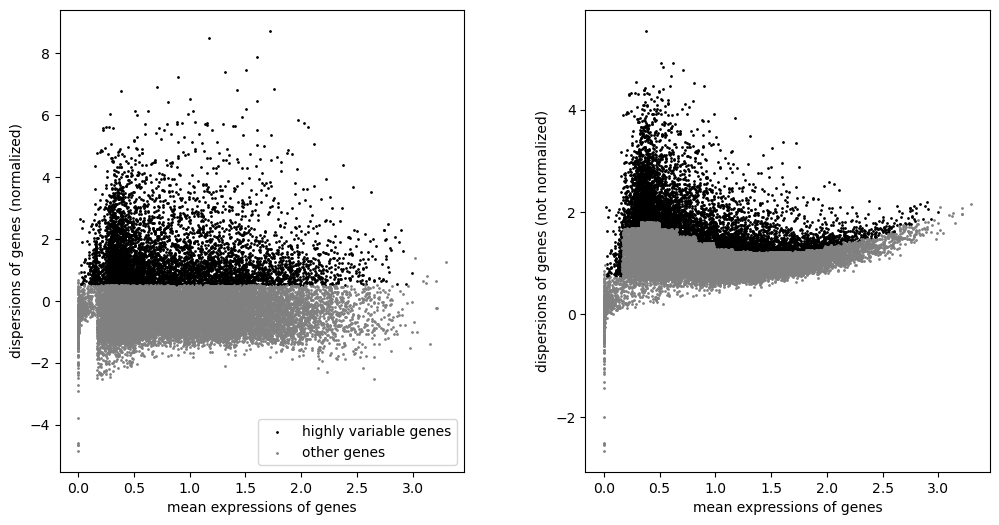

In [49]:
sc.pp.highly_variable_genes(windows, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(windows)

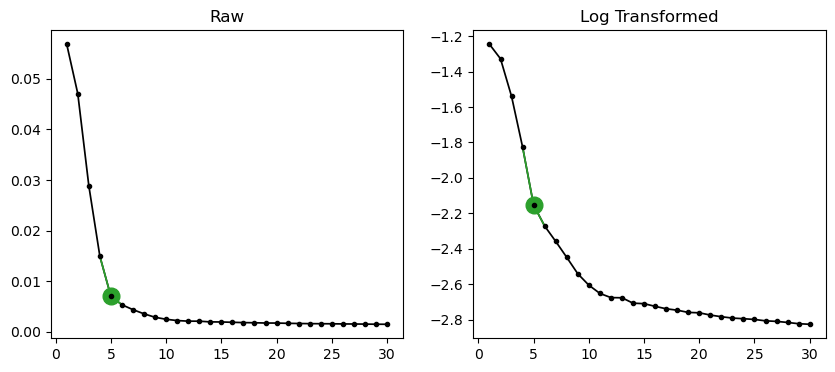

In [50]:
epi.pp.pca(windows, n_comps=30, use_highly_variable=True, svd_solver="arpack")
n_comps = epi.pp.find_elbow(windows, use_log=False, show_anno=False)

In [51]:
epi.pp.neighbors(windows, n_pcs=n_comps, method="umap")
epi.tl.umap(windows)

In [52]:
windows.obs["karyotype"] = windows.obs.karyotype.astype("category")

colors = {x: cmap_clones[i] for i, x in enumerate(windows.obs.karyotype.cat.categories)}
colors

{'1.1': '#730002',
 '1.2': '#ffb4b2',
 '2.1': '#027300',
 '2.2.1': '#5dd25d',
 '2.2.2': '#b2ffb4',
 '3.1': '#000473',
 '3.2.1': '#494bb9',
 '3.2.2': '#8e8ce6',
 '3.2.3': '#b5b2ff'}

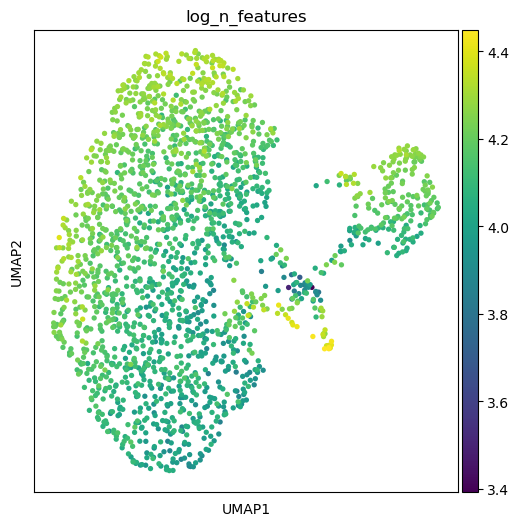

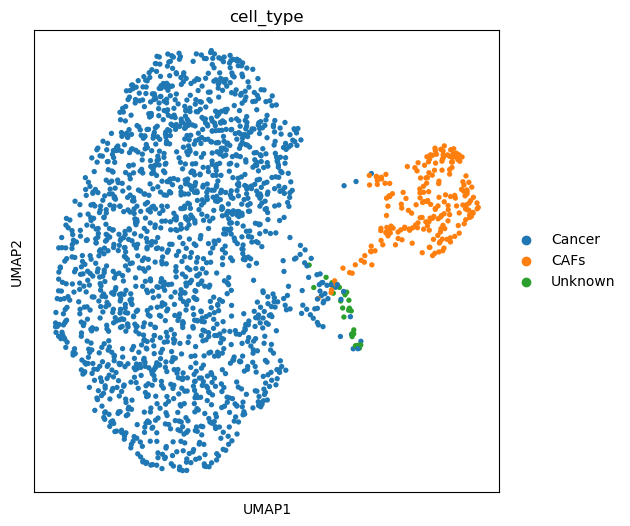

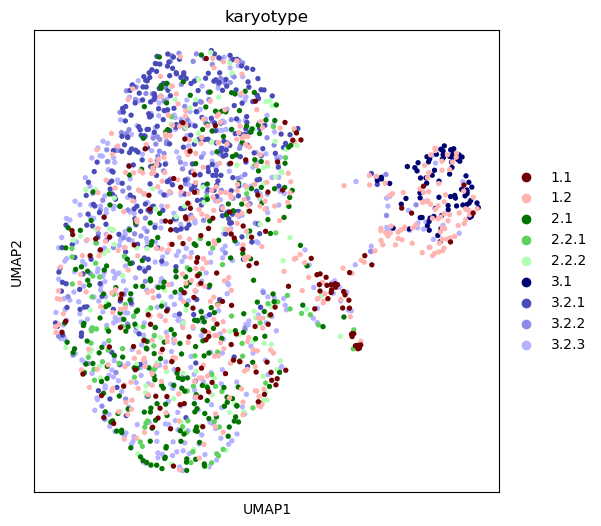

In [53]:
plt.rcParams["figure.figsize"]= (6, 6)
epi.pl.umap(windows, color=["log_n_features"], ncols=4, save="_windows_nfeat.png")
epi.pl.umap(windows, color=["cell_type"], color_map=cmap, ncols=4, save="_windows_cell_types.png")
epi.pl.umap(windows, color=["karyotype"], palette=colors, ncols=4, save="_windows_karyotypes.png")